In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
import xgboost as xgb
import math
import statsmodels.api as sm
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import scipy.stats as stats
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import GridSearchCV

In [76]:
df = pd.read_csv('credit_risk.csv')
df

,default_label,age,gender,edu,housing,income,job_occupation,past_bad_credit,married
0,0,49,0,2,1,3782.410356,0,1,1
1,0,62,1,3,1,11516.000660,0,1,1
2,0,43,1,2,1,1746.632495,1,1,1
3,0,59,0,0,0,1195.975234,1,1,1
4,0,58,1,4,1,7217.466097,0,1,1
...,...,...,...,...,...,...,...,...,...
13977,0,36,1,2,1,6856.358688,0,1,0
13978,0,44,0,0,1,2245.684172,0,1,0
13979,0,47,0,1,1,14793.528320,0,1,1
13980,0,62,0,0,1,2118.337362,0,1,1


In [77]:
# create summary table
df_summary = df.describe().T
df_summary.index = df_summary.index.str.replace('_','\_',regex=True)
df_summary.to_latex('table/data_description.tex',columns=['count','mean','std','min','max'],float_format="%.2f",bold_rows=True, caption='Data Description', label='tab:data_description')

In [78]:
default_rate = df['default_label'].sum() / len(df)
print(f'The default rate of sample is {default_rate:.2%}')

The default rate of sample is 2.20%


In [79]:
# plots the roc curve based of the probabilities
def plot_roc_curve(true_y, y_prob, model_name):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    auc = roc_auc_score(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve of {model_name} (AUC={auc:.3f})')
    plt.savefig(f'./fig/roc_curve_{model_name}.png')
    return [plt, auc]

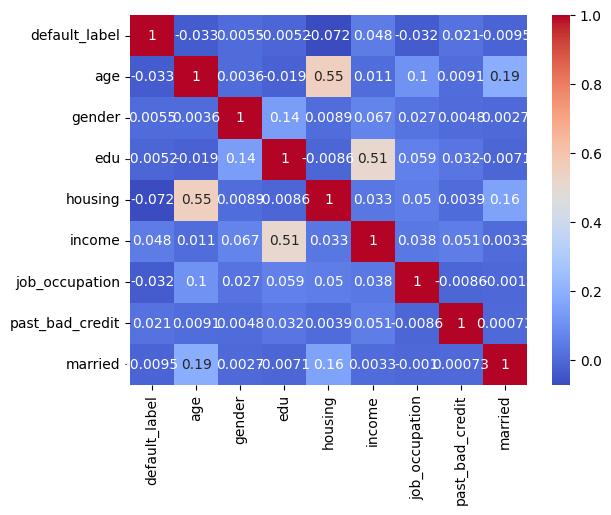

In [80]:
# Plot heatmap
# sns.heatmap(df.drop(columns=['default_label']).corr(), annot=True, cmap='coolwarm')
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

# Save the heatmap as an image
plt.savefig('fig/variable_heatmap.png')

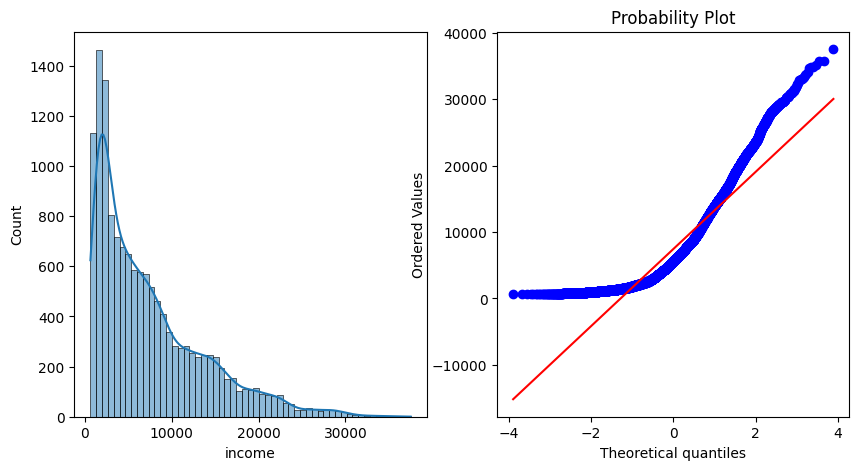

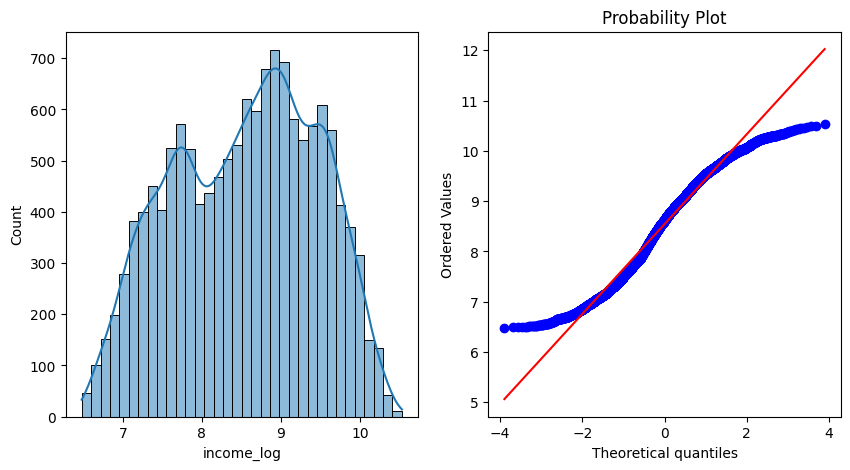

In [81]:
## Transformation of skewed variables
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(df['income'], kde=True)
plt.subplot(1,2,2)
stats.probplot(df['income'], dist="norm", plot=plt)   # QQ Plot
plt.savefig('./fig/income_distribution.png')

# Log transformation
logTr = ColumnTransformer(transformers=[("lg", FunctionTransformer(np.log1p), ['income'])])
df['income_log'] = logTr.fit_transform(df)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(df['income_log'], kde=True)
plt.subplot(1,2,2)
stats.probplot(df['income_log'], dist="norm", plot=plt)   # QQ Plot
plt.savefig('./fig/income_distribution_log_transform.png')

In [82]:
# data prep for out-of-sample
df_train = df[:10000]
df_test = df[10001:]
y_train = df_train['default_label']
X_train = df_train.drop(columns=['default_label','income'])
X_test = df_test.drop(columns=['default_label','income'])
y_test = df_test['default_label']

# Simple Logistic Model

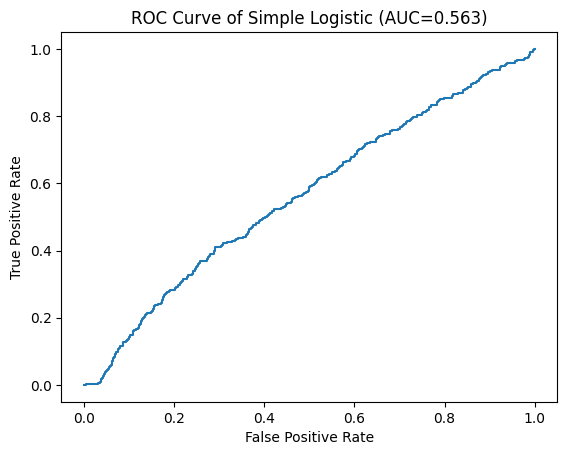

In [83]:
mod = LogisticRegression()
rres = mod.fit(y = df['default_label'], X=df[['past_bad_credit', 'income']])
_, auc_simplog = plot_roc_curve(df['default_label'], mod.predict_proba(df[['past_bad_credit', 'income']])[:,1],'Simple Logistic')


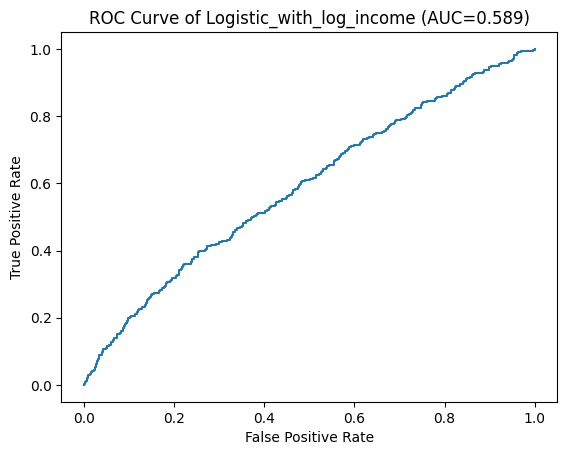

In [84]:
mod = LogisticRegression()
rres = mod.fit(y = df['default_label'], X=df[['past_bad_credit', 'income_log']])
_, auc_simplog_logtransform = plot_roc_curve(df['default_label'], mod.predict_proba(df[['past_bad_credit', 'income_log']])[:,1],'Logistic_with_log_income')

# Full Logistic Model

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


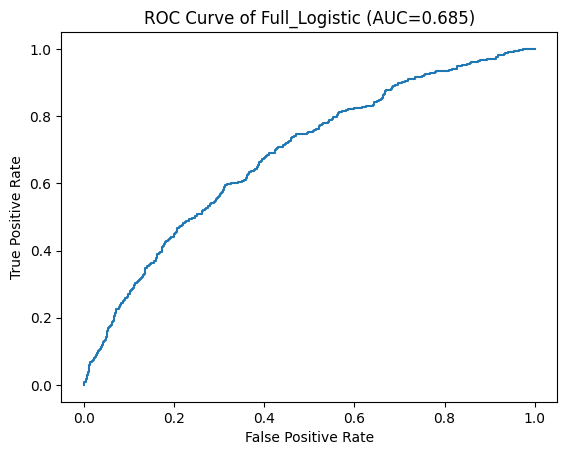

In [85]:
mod = LogisticRegression()
X=df.drop(columns=['default_label','income'])
rres = mod.fit(y = df['default_label'], X=X)
_, auc_log = plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'Full_Logistic')

# SVM/ Random Forest

## SVM

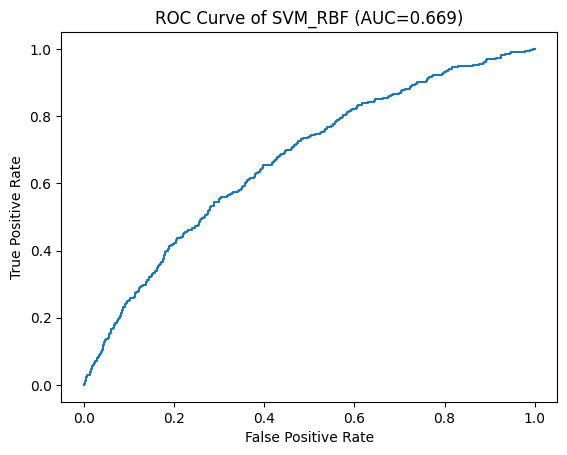

In [86]:
# SVM using RBF kernel
mod = svm.SVC(class_weight='balanced',kernel='rbf', probability=True)
rres = mod.fit(y = df['default_label'], X=X)
_, auc_rbfsvm = plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'SVM_RBF')

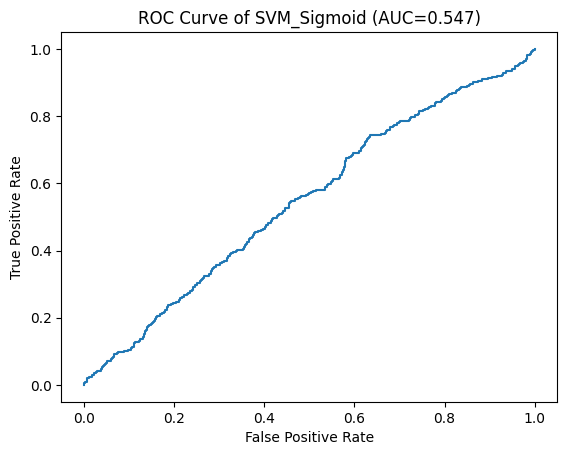

In [87]:
# sigmoid SVM
mod = svm.SVC(class_weight='balanced',kernel='sigmoid', probability=True)
rres = mod.fit(y = df['default_label'], X=X)
_, auc_sigmoidsvm = plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'SVM_Sigmoid')

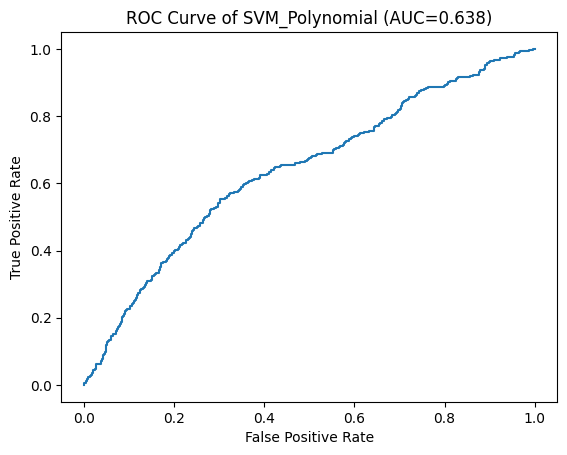

In [88]:
# polynomial SVM
mod = svm.SVC(class_weight='balanced',kernel='poly', probability=True)
rres = mod.fit(y = df['default_label'], X=X)
_, auc_polysvm = plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'SVM_Polynomial')

## Random Forest

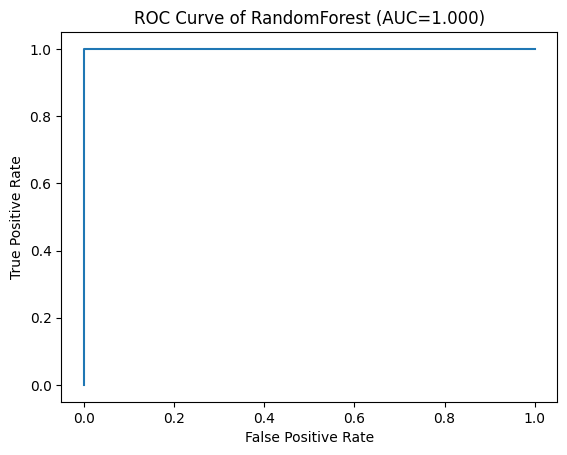

In [89]:
mod = RandomForestClassifier()
rres = mod.fit(y = df['default_label'], X=X)
_, auc_RF = plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'RandomForest')

## Neural Network

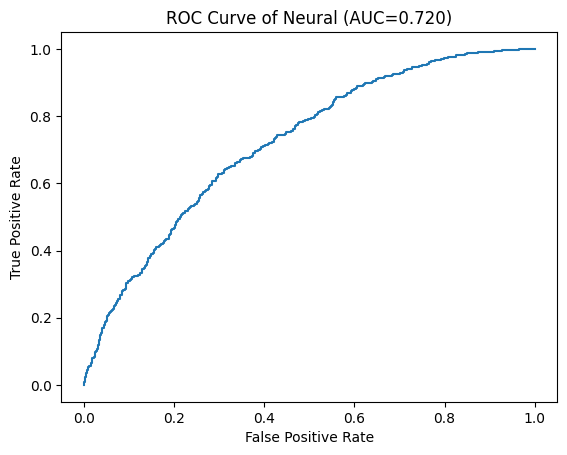

In [90]:
mod = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000)
rres = mod.fit(y = df['default_label'], X=X)
_, auc_neural = plot_roc_curve(df['default_label'], mod.predict_proba(X)[:,1],'Neural')

## XGBoosting

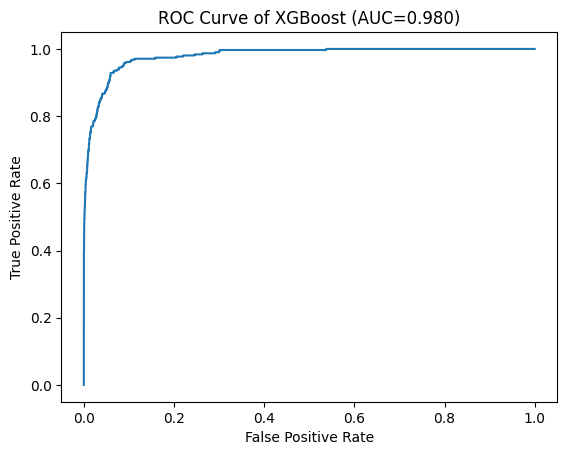

In [91]:
# Create an instance of the XGBoost classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X, df['default_label'])
_, auc_XGBoosting = plot_roc_curve(df['default_label'], xgb_model.predict_proba(X)[:,1],'XGBoost')

# Out-of-Sample Test

## Logistic

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


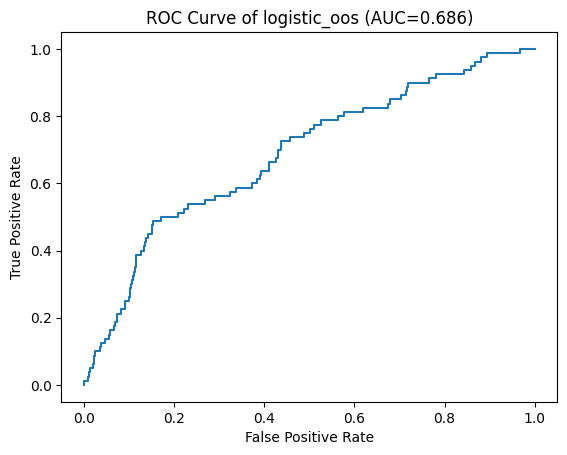

In [92]:
# Create a logistic regression model
logreg = LogisticRegression()
# Fit the model on the training data
logreg.fit(X_train, y_train)

param_log = logreg.get_params()

# Plot the ROC curve
_, auc_log_oos = plot_roc_curve(y_test, logreg.predict_proba(X_test)[:,1],'logistic_oos')

In [131]:
param_log

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## SVM

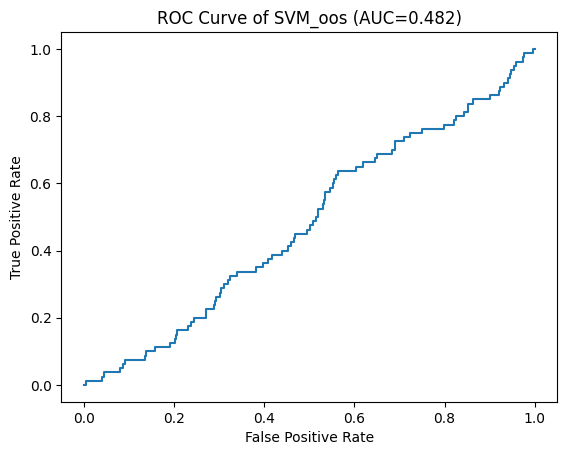

In [93]:
mod = svm.SVC(kernel='rbf', probability=True)
rres = mod.fit(y = y_train, X=X_train)
param_svm = mod.get_params()
_, auc_svm_oos = plot_roc_curve(y_test, mod.predict_proba(X_test)[:,1],'SVM_oos')

In [132]:
param_svm

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Random Forest

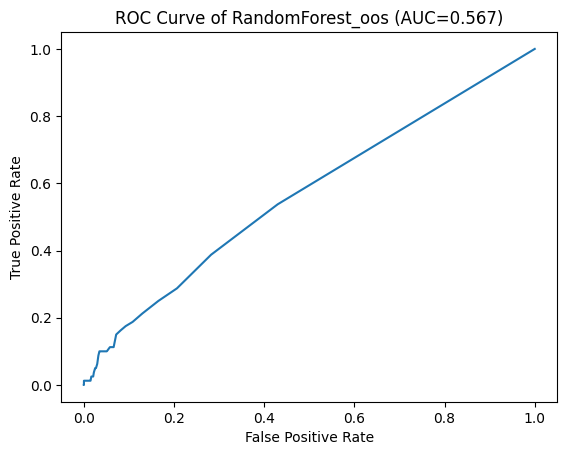

In [94]:
mod = RandomForestClassifier()
rres = mod.fit(y = y_train, X=X_train)
param_RF = mod.get_params()
_, auc_RFoos = plot_roc_curve(y_test, mod.predict_proba(X_test)[:,1],'RandomForest_oos')

In [133]:
param_RF

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## XGBoosting


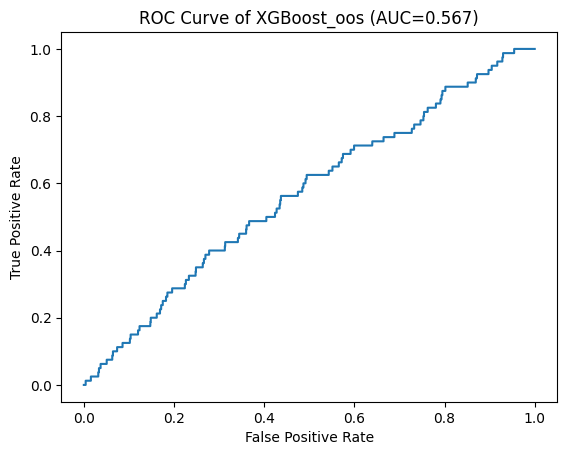

In [95]:
# Create an instance of the XGBoost classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
param_XGB = mod.get_params()
_, auc_XGBoostingoos = plot_roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1],'XGBoost_oos')

In [134]:
param_XGB

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Neural Network

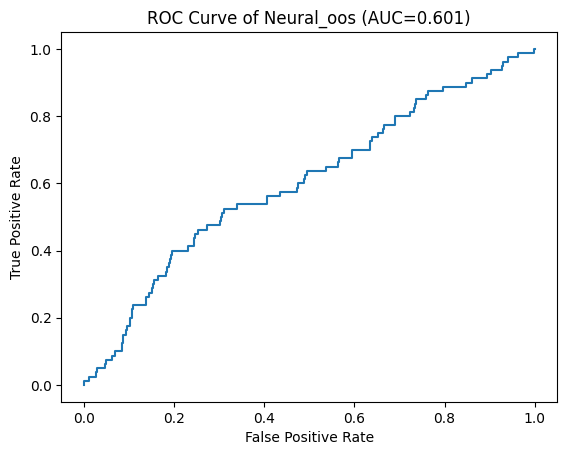

In [96]:
mod = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=1000)
rres = mod.fit(y = y_train, X=X_train)
param_nn = mod.get_params()
_, auc_neural_oos = plot_roc_curve(y_test, mod.predict_proba(X_test)[:,1],'Neural_oos')

In [135]:
param_nn

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100, 100),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

# Hypertuning

## Logistic

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

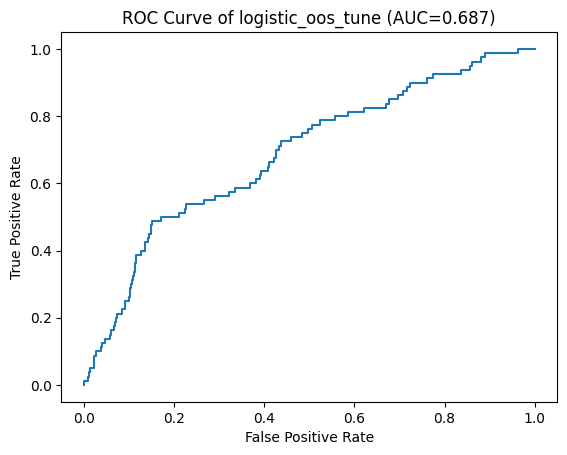

In [97]:
# Create a logistic regression model
logreg = LogisticRegression()

# Define the parameter grid for tuning
param_grid_log = {'C': [0.001, 0.01, 0.1, 1, 10]}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid_log, scoring='roc_auc', cv=5)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model_log = grid_search.best_estimator_
best_params_log = grid_search.best_params_

# Fit the best model on the training data
best_model_log.fit(X_train, y_train)


# Plot the ROC curve
_, auc_log_oos_tune = plot_roc_curve(y_test, best_model_log.predict_proba(X_test)[:,1],'logistic_oos_tune')

In [136]:
best_params_log

{'C': 10}

## SVM

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.540 total time=   3.6s
[CV 2/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.573 total time=   3.5s
[CV 3/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.503 total time=   3.4s
[CV 4/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.586 total time=   3.2s
[CV 5/5] END ......C=100, gamma=0.1, kernel=rbf;, score=0.524 total time=   3.1s
[CV 1/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.591 total time=  20.2s
[CV 2/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.597 total time=  20.7s
[CV 3/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.541 total time=  22.0s
[CV 4/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.582 total time=  20.2s
[CV 5/5] END .....C=100, gamma=0.01, kernel=rbf;, score=0.620 total time=  21.6s
[CV 1/5] END ....C=100, gamma=0.001, kernel=rbf;, score=0.502 total time=   4.6s
[CV 2/5] END ....C=100, gamma=0.001, kernel=rbf;,

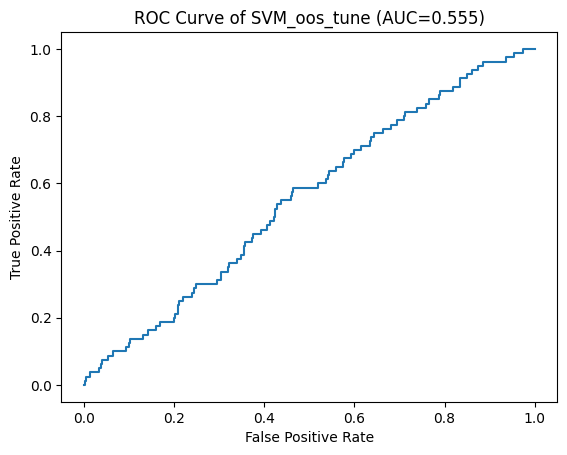

In [98]:
# defining parameter range 
param_grid_svm = {'C': [10, 100],  
              'gamma': [0.1, 0.01, 0.001], 
              'kernel': ['rbf']}  

grid_search = GridSearchCV(svm.SVC(probability=True), param_grid_svm, refit = True, verbose = 3,scoring='roc_auc') 

# fitting the model for grid search 
grid_search.fit(X_train, y_train) 

# Get the best parameters and best AUC score
best_params_svm = grid_search.best_params_
best_model_svm = grid_search.best_estimator_

# Train the random forest model with the best parameters
best_model_svm.fit(X_train,y_train)

_, auc_svm_oos_tune = plot_roc_curve(y_test, best_model_svm.predict_proba(X_test)[:,1],'SVM_oos_tune')

In [137]:
best_params_svm

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

## Random Forest

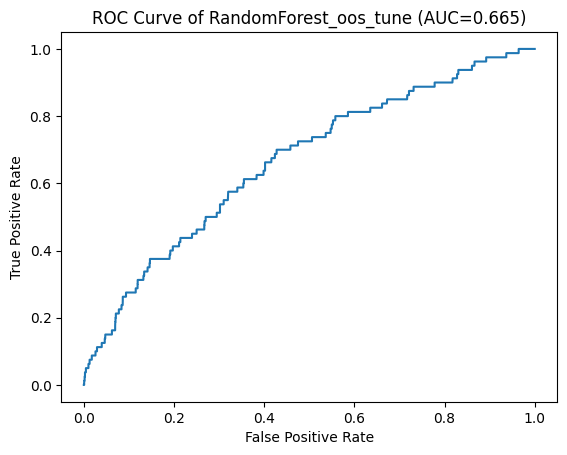

In [99]:
# Define the parameter grid for tuning
param_grid_RF = {
    'n_estimators': [100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]   
}

# Create the grid search object
grid_search = GridSearchCV(RandomForestClassifier(), param_grid_RF, cv=5, scoring='roc_auc')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best AUC score
best_params_RF = grid_search.best_params_
best_model_RF = grid_search.best_estimator_

# Train the random forest model with the best parameters
best_model_RF.fit(X_train,y_train)

_, auc_RFoos_tune = plot_roc_curve(y_test, best_model_RF.predict_proba(X_test)[:,1],'RandomForest_oos_tune')

In [138]:
best_params_RF

{'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

## XGBoosting


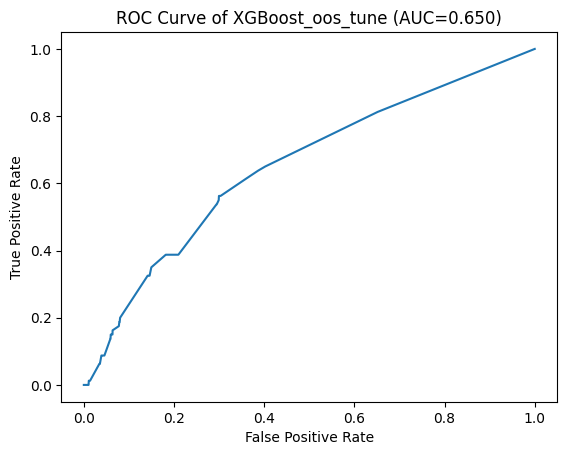

In [100]:
# Define the parameter grid for tuning
param_grid_XGB = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Create a GridSearchCV object with the XGBoost classifier and parameter grid
grid_search = GridSearchCV(xgb.XGBClassifier(), param_grid=param_grid_XGB, scoring='roc_auc', cv=5)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best AUC score
best_params_XGB = grid_search.best_params_
best_model_XGB = grid_search.best_estimator_

best_model_XGB.fit(X_train, y_train)

_, auc_XGBoostingoos_tune = plot_roc_curve(y_test, best_model_XGB.predict_proba(X_test)[:,1],'XGBoost_oos_tune')

In [139]:
best_params_XGB

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}

## Neural Network

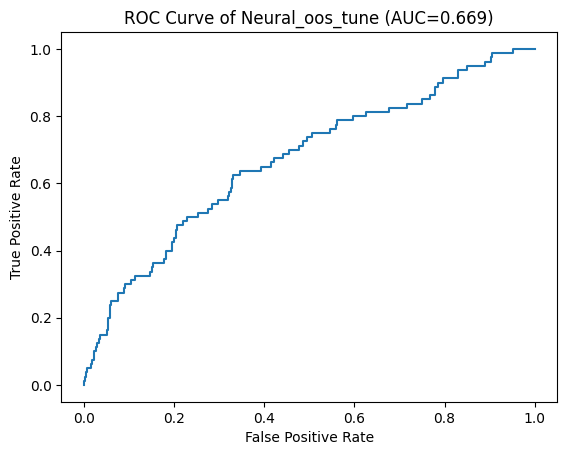

In [101]:
# Define the parameter grid for tuning
param_grid_nn = {
    'hidden_layer_sizes': [(100,), (100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(MLPClassifier(max_iter=1000), param_grid_nn, scoring='roc_auc', cv=5)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model_nn = grid_search.best_estimator_
best_params_nn = grid_search.best_params_

# Fit the best model on the training data
best_model_nn.fit(X_train, y_train)

_, auc_neural_oos_tune = plot_roc_curve(y_test, best_model_nn.predict_proba(X_test)[:,1],'Neural_oos_tune')

In [140]:
best_params_nn

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100)}

# Conclusion

In [102]:
auc_compare = (pd.DataFrame(
    {'Model': ['Simple Logistic', 'Simple Logistic with log income', 'Full Logistic', 'SVM RBF', 'SVM Sigmoid', 'SVM Poly', 'Random Forest', 'XGBoosting', 'Neural Network'],
     'auc': [auc_simplog, auc_simplog_logtransform, auc_log, auc_rbfsvm, auc_sigmoidsvm, auc_polysvm, auc_RF , auc_XGBoosting, auc_neural]
}))
auc_compare.to_latex('table/auc_compare.tex',index=False,float_format="%.3f",caption='AUC Comparison', label='tab:auc_compare')

In [103]:
auc_oos_compare = (pd.DataFrame(
    {'Model': ['Logistic', 'SVM RBF', 'Random Forest', 'XGBoosting', 'Neural Network'],
     'auc': [auc_log_oos, auc_svm_oos, auc_RFoos, auc_XGBoostingoos, auc_neural_oos],
     'auc\_tuned':[auc_log_oos_tune, auc_svm_oos_tune, auc_RFoos_tune, auc_XGBoostingoos_tune, auc_neural_oos_tune]
}))
auc_oos_compare.to_latex('table/auc_oos_compare.tex',index=False,float_format="%.3f",caption='AUC Comparison (Out of Sample)', label='tab:auc_oos_compare')

In [143]:
# hyperparam = (pd.DataFrame({
#     'Model': ['Logistic', 'SVM RBF', 'Random Forest', 'XGBoosting', 'Neural Network'],
#     'tuned\_parameters': [list(best_params_log.keys()),list(best_params_svm.keys()),list(best_params_RF.keys()),list(best_params_XGB.keys()),list(best_params_nn.keys())]
# }))
# hyperparam = hyperparam.explode('tuned\_parameters')
# for i in range(len(hyperparam)):
#     hyperparam['baseline\_parameters'][i] = 
# 'baseline\_parameters':[param_log,param_svm,param_RF,param_XGB,param_nn],
#     # 'parameter\_grid':[param_grid_log,param_grid_svm,param_grid_RF,param_grid_XGB,param_grid_nn],
#     # 'best\_parameters':[best_params_log,best_params_svm,best_params_RF,best_params_XGB,best_params_nn]



# hyperparam.to_latex('table/hyperparam.tex',index=False,caption='Hyperparameter Tuning', label='tab:hyperparam',multirow=True)